In [1]:
import pylab as py
import numpy as np
import random as rn
import time
import scipy.special.cython_special
%run Jackknife.ipynb
pi = np.pi

In [23]:
def BesselITable(beta,max_nu):
    '''
    Generates a table (list) with the values of the modified Bessel function
    of the first kind.
    ''' 
    Inu = [] #Bessel function
    Inu1 = [] #First derivative
    Inu2 = [] #Second derivative
    for i in range(max_nu+1):
        Inu.append(scipy.special.iv(i, beta, out=None))
        Inu1.append(scipy.special.ivp(i, beta, n=1))
        Inu2.append(scipy.special.ivp(i, beta, n=2))
    return Inu, Inu1, Inu2

def BesselITableCaller(beta,Jij,Inu,Inu1,Inu2):
    '''
    This function decides whether to call a function from the table 
    or to generate a new one which is not in the table.
    '''
    Jij = int(Jij)
    max_nu = len(Inu)-1  
    if abs(Jij) <= max_nu:
        Iv, Iv1, Iv2 = Inu[abs(Jij)], Inu1[abs(Jij)], Inu2[abs(Jij)]
    else:
        Iv, Iv1, Iv2 = scipy.special.iv(Jij, beta, out=None), scipy.special.ivp(Jij, beta, n=1), scipy.special.ivp(Jij, beta, n=2)
    return Iv, Iv1, Iv2

def Energy(L,beta,FluxX, FluxY,FluxZ,Inu,Inu1,Inu2):
    '''
    Computes E and E² for each measurement.
    '''
    En = 0 #Energy
    En2 = 0  #Squared energy
    for i in range(L): 
        for j in range(L):
            for k in range(L):
                IvX, Iv1X, Iv2X = BesselITableCaller(beta,FluxX[i,j,k],Inu,Inu1,Inu2)
                IvY, Iv1Y, Iv2Y = BesselITableCaller(beta,FluxY[i,j,k],Inu,Inu1,Inu2)
                IvZ, Iv1Z, Iv2Z = BesselITableCaller(beta,FluxZ[i,j,k],Inu,Inu1,Inu2)
                En += Iv1X/IvX + Iv1Y/IvY + Iv1Z/IvZ
                En2 += Iv2X/IvX + Iv2Y/IvY + Iv2Z/IvZ - (Iv1X/IvX)**2 - (Iv1Y/IvY)**2 - (Iv1Z/IvZ)**2            
    En2 += En**2
    return -En, En2
            
def AccRatio(mu,beta,L,Masha,FluxX, FluxY,FluxZ):
    '''
    This function computes the acceptance ratio based on the flux between
    two neighbouring sites.
    '''
    if mu == 0: 
        FluxIni = FluxX[Masha[0],Masha[1],Masha[2]] #Flux from (mx, my, mz) to (mx+1, my, mz)
    elif mu == 1:
        FluxIni = -FluxX[Masha[0],(Masha[1]-1)%L,Masha[2]] #Flux from (mx, my, mz) to (mx-1, my, mz)
    elif mu == 2:
        FluxIni = -FluxY[(Masha[0]-1)%L,Masha[1],Masha[2]] #Flux from (mx, my, mz) to (mx, my + 1, mz)
    elif mu == 3:
        FluxIni = FluxY[Masha[0],Masha[1],Masha[2]] #Flux from (mx, my, mz) to (mx, my - 1, mz)
    elif mu == 4:
        FluxIni = -FluxZ[Masha[0],Masha[1],(Masha[2]-1)%L] #Flux from (mx, my, mz) to (mx, my, mz+1)
    elif mu == 5:
        FluxIni = FluxZ[Masha[0],Masha[1],Masha[2]] #Flux from (mx, my, mz) to (mx, my, mz-1)
    FluxFin = FluxIni + 1    
    R = scipy.special.iv(FluxFin, beta, out=None)/scipy.special.iv(FluxIni, beta, out=None)          
    return R
            
def WA_sweep(L,beta,FluxX, FluxY, FluxZ, Masha):
    '''
    Performs one sweep with the worm algorithm, or better to say moves the head
    of the worm.
    '''
    mu = rn.randint(0, 5) 
    #0 --> +x direction, 1 --> -x direction, 2 --> +y direction, 3 --> -y direction
    #4 --> +z direction, 5 --> -z direction
    R = AccRatio(mu,beta,L,Masha,FluxX, FluxY,FluxZ)
    r = rn.random() #random number between zero and one  
    if r < R:
        if mu == 0: 
            FluxX[Masha[0], Masha[1],Masha[2]] += 1   #Create bond from Masha to the right site -->
            Masha[1] = (Masha[1]+1) % L #move masha one site to the right           
        elif mu == 1: 
            FluxX[Masha[0],(Masha[1]-1) % L,Masha[2]] -= 1  #Create bond from Masha to the left site <--
            Masha[1] = (Masha[1]-1) % L #move masha one site to the left    
        elif mu == 2: 
            FluxY[(Masha[0]-1)%L, Masha[1],Masha[2]] -= 1 #Create bond from Masha to the site in front         
            Masha[0] = (Masha[0]-1) % L #move masha to the front   
        elif mu == 3: 
            FluxY[Masha[0], Masha[1],Masha[2]] += 1 #Create bond from Masha to the site behind
            Masha[0] = (Masha[0]+1) % L #move masha behind
        elif mu == 4:
            FluxZ[Masha[0],Masha[1],(Masha[2]-1)%L] -= 1 #move from (mx, my, mz) to (mx, my, mz+1)
            Masha[2] = (Masha[2]-1) % L
        elif mu == 5:
            FluxZ[Masha[0],Masha[1],Masha[2]] += 1 #move from (mx, my, mz) to (mx, my, mz-1)
            Masha[2] = (Masha[2] +1) % L
    return Masha, FluxX, FluxY, FluxZ

def WA_XY3d(beta,L,Ntherm,Nmeas,Nsteps):
    '''
    Worm algorithm for one value of beta.
    '''
    Inu, Inu1, Inu2 = BesselITable(beta,5) #This computes the modified bessel functions and its derivatives up to nu = 5
    Ira = [rn.randint(0, L-1), rn.randint(0,L-1), rn.randint(0,L-1)] #randint(a,b) generates a random number r\in[a,b] (closed interval)
    Masha = [Ira[0],Ira[1],Ira[2]]
    FluxX, FluxY, FluxZ = np.zeros((L,L,L)), np.zeros((L,L,L)), np.zeros((L,L,L))
    Chi = []
    En = []
    En2 = []
    tau = []
    #----Thermalization steps----#
    for i in range(Ntherm):
        if Masha == Ira: 
            Ira = [rn.randint(0, L-1), rn.randint(0,L-1), rn.randint(0,L-1)]
            Masha = [Ira[0],Ira[1], Ira[2]]
            tau = 0
        else:
            tau += 1
        Masha, FluxX, FluxY, FluxZ = WA_sweep(L,beta,FluxX, FluxY, FluxZ, Masha)
    #---------------------------#
    count = 0
    #----Measurements----#
    while count<Nmeas:
        if Masha == Ira:
            E, E2 = Energy(L,beta,FluxX,FluxY,FluxZ,Inu,Inu1,Inu2) #E and E²
            En.append(E)
            En2.append(E2)
            Chi.append(tau)
            tau = 0
            Ira = [rn.randint(0, L-1), rn.randint(0,L-1), rn.randint(0,L-1)]
            Masha = [Ira[0],Ira[1], Ira[2]]
            count += 1 #Update the measurements counter.
        else:
            tau += 1
        Masha, FluxX, FluxY, FluxZ = WA_sweep(L,beta,FluxX, FluxY, FluxZ, Masha)
    #----Decorrelation steps----# I am not sure whether I actually need this ...
        for j in range(Nsteps): 
            if Masha == Ira:
                Ira = [rn.randint(0, L-1), rn.randint(0,L-1), rn.randint(0,L-1)]
                Masha = [Ira[0],Ira[1], Ira[2]]
            Masha, FluxX, FluxY, FluxZ = WA_sweep(L,beta,FluxX, FluxY,FluxZ, Masha)
            
    En = np.array(En)
    E = np.mean(En) #<E>
    dE = Jerr_v1(En,20)  #d<E>
    En2 = np.array(En2) 
    E2 =np.mean(En2) #<E²>
    dE2 = Jerr_v1(En2,20) #d<E²>
    
    Cv = beta**2 * (E2-E**2)  #Cv*L² = beta²*(<E²>-<E>²)
    dCv = abs(beta**2 * (dE2 + 2*E*dE )) #dCv  
    
    Chi = np.array(Chi) 
    chi = np.mean(Chi) #Chi = <M>
    dchi = Jerr_v1(Chi,20) 
    return chi, dchi, E, dE, Cv, dCv

def ChidChiResults(L,Ntherm,Nmeas,Nsteps,beta_in,beta_fin,beta_step):
    '''
    Performs simulations for several values of beta.
    '''
    beta = np.linspace(beta_in,beta_fin,beta_step)
    Chi, dChi = [], []
    En, dEn = [], []
    Cv, dCv = [], []
    for i in range(len(beta)):
        chi, dchi, E, dE, cv, dcv = WA_XY3d(beta[i],L,Ntherm,Nmeas,Nsteps)
        Chi.append(chi)
        dChi.append(dchi)
        En.append(E)
        dEn.append(dE)
        Cv.append(cv)
        dCv.append(dcv)
        print('i',i,'beta',beta[i],'T',1/beta[i])
        print('chi',chi,'+-',dchi)
        print('Energy',E,'+-',dE)
        print('Cv',cv,'+-',dcv)
        print('---------------------------')
    dChi = np.array(dChi)
    Chi = np.array(Chi)
    En = np.array(En)
    dEn = np.array(dEn)
    Cv = np.array(Cv)
    dCv = np.array(dCv)
    return Chi, dChi, En, dEn, Cv, dCv

In [33]:
Ntherm, Nmeas, Nsteps = 10000, 10000, 10
beta_ini, beta_fin, beta_step = 0.2, 0.9, 20
beta = np.linspace(beta_ini,beta_fin,beta_step)
L = 8
print('L={0}'.format(L))
Chi, dChi, E, dE, Cv, dCv = ChidChiResults(L,Ntherm,Nmeas,Nsteps,beta_ini,beta_fin,beta_step)

L=8
i 0 beta 0.2 T 5.0
chi 1.1971 +- 0.023266182823099665
Energy -157.6508671910381 +- 1.2740587925348388
Cv 33.481874756325276 +- 0.7075996680055006
---------------------------
i 1 beta 0.2368421052631579 T 4.222222222222222
chi 1.7057 +- 0.0356961666820048
Energy -191.95071509771057 +- 1.1871638942690017
Cv 51.208582068275405 +- 0.6343034209825842
---------------------------
i 2 beta 0.2736842105263158 T 3.6538461538461537
chi 2.4445 +- 0.05801159140070287
Energy -227.2390295092892 +- 1.8622463332720993
Cv 79.92770994907605 +- 3.1341610395134993
---------------------------
i 3 beta 0.31052631578947365 T 3.2203389830508478
chi 3.5347 +- 0.066789579237609
Energy -265.5367185909288 +- 1.38683253427185
Cv 100.02286010722928 +- 1.4228455179361643
---------------------------
i 4 beta 0.34736842105263155 T 2.878787878787879
chi 5.6782 +- 0.1580976313947545
Energy -305.12364930451827 +- 2.053728139009147
Cv 146.35839402954906 +- 3.3403832076197015
---------------------------
i 5 beta 0.38421

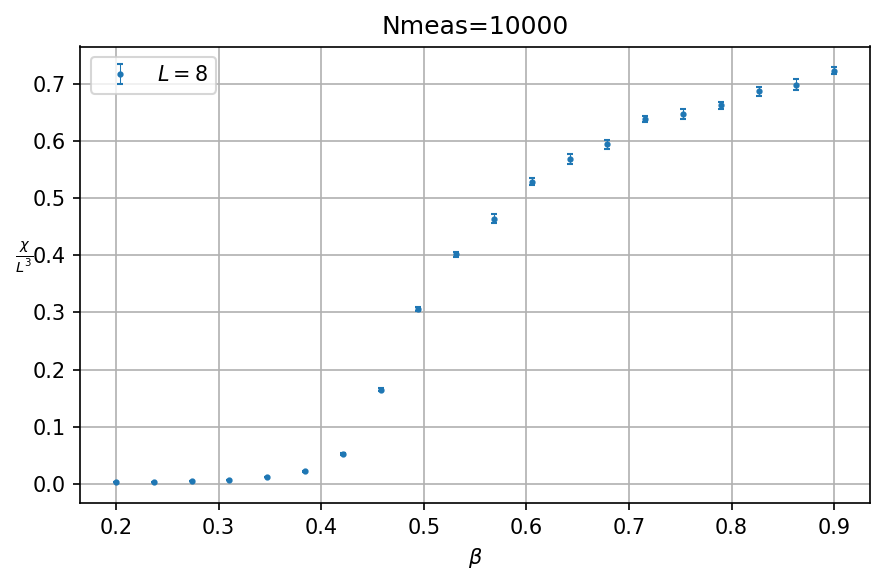

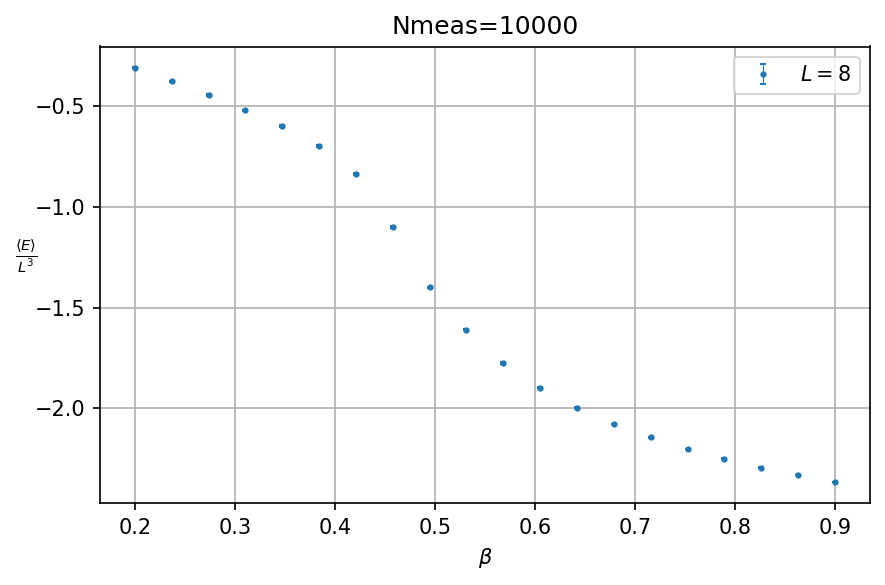

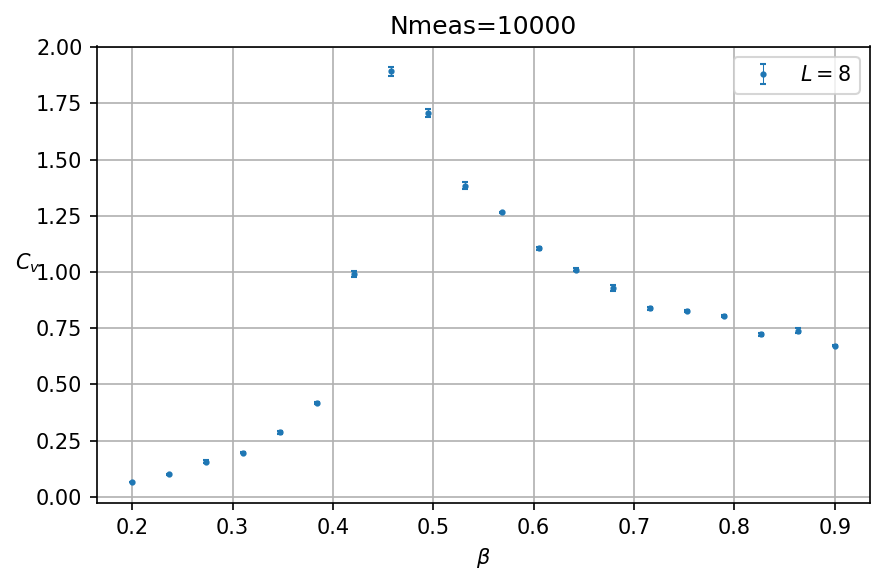

In [41]:
fig = py.figure(dpi=150)
py.errorbar(beta,Chi/L**3,yerr=dChi/L**3,fmt='o',markersize='2',\
elinewidth=0.5,solid_capstyle='projecting', capsize=1.5,label=r'$L=${0}'.format(L))
py.title('Nmeas={0}'.format(Nmeas))
py.xlabel(r'$\beta$')
py.ylabel(r'$\frac{\chi}{L^3}$',rotation=0)
py.legend()
py.grid()
py.tight_layout()
#fig.savefig('3DXYChiL8-HighPrec.pdf')
py.show()


fig = py.figure(dpi=150)
py.errorbar(beta,E/L**3,yerr=dE/L**3,fmt='o',markersize='2',\
elinewidth=0.5,solid_capstyle='projecting', capsize=1.5,label=r'$L=${0}'.format(L))
py.title('Nmeas={0}'.format(Nmeas))
py.xlabel(r'$\beta$')
py.ylabel(r'$\frac{\langle E \rangle}{L^3}$',rotation=0)
py.legend()
py.grid()
py.tight_layout()
#fig.savefig('3DXYEL8-HighPrec.pdf')
py.show()

fig = py.figure(dpi=150)
py.errorbar(beta,Cv/L**3,yerr=dCv/L**3,fmt='o',markersize='2',\
elinewidth=0.5,solid_capstyle='projecting', capsize=1.5,label=r'$L=${0}'.format(L))
py.title('Nmeas={0}'.format(Nmeas))
py.xlabel(r'$\beta$')
py.ylabel(r'$C_v$',rotation=0)
py.legend()
py.grid()
py.tight_layout()
#fig.savefig('3DXYCvL8-HighPrec.pdf')
py.show()